In [1]:
# ----------------------------------------
# 1. IMPORTAR LIBRERÍAS
# ----------------------------------------
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Multiply, Lambda, RepeatVector, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2  # Añadimos esta importación
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# Configurar semillas aleatorias para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ----------------------------------------
# 2. CARGA Y PREPROCESAMIENTO DE DATOS
# ----------------------------------------
# Cargar el CSV y eliminar la columna DateTimes
df = pd.read_csv('./dataset_rttov_rad.csv')
df = df.drop(columns=['DateTimes'])

# Convertir columnas de texto a arrays numéricos
P_values    = np.array([np.array(eval(row)) for row in df['P']])
T_values    = np.array([np.array(eval(row)) for row in df['T']])
Q_values    = np.array([np.array(eval(row)) for row in df['Q']])
CO2_values  = np.array([np.array(eval(row)) for row in df['CO2']])
Angles      = np.array([np.array(eval(row)) for row in df['Angles']])
SurfGeom    = np.array([np.array(eval(row)) for row in df['SurfGeom']])
Skin        = np.array([np.array(eval(row)) for row in df['Skin']])
s2m         = np.array([np.array(eval(row)) for row in df['s2m']])
SurfType    = np.array([np.array(eval(row)) for row in df['SurfType']])

# Calcular medias
P_mean   = np.mean(P_values, axis=1)
T_mean   = np.mean(T_values, axis=1)
Q_mean   = np.mean(Q_values, axis=1)
CO2_mean = np.mean(CO2_values, axis=1)

# Crear DataFrames
SurfGeom_df = pd.DataFrame(SurfGeom, columns=[f"SurfGeom_{i}" for i in range(SurfGeom.shape[1])])
Angles_df   = pd.DataFrame(Angles,   columns=[f"Angles_{i}" for i in range(Angles.shape[1])])
Skin_df     = pd.DataFrame(Skin,     columns=[f"Skin_{i}" for i in range(Skin.shape[1])])
s2m_df      = pd.DataFrame(s2m,      columns=[f"s2m_{i}" for i in range(s2m.shape[1])])
SurfType_df = pd.DataFrame(SurfType, columns=[f"SurfType_{i}" for i in range(SurfType.shape[1])])

# Procesar resultados
Results    = np.array([np.array(eval(row)) for row in df['Result']])
results_df = pd.DataFrame(Results, columns=[f"Result_{i}" for i in range(Results.shape[1])])

# Crear DataFrame final
stats_df = pd.DataFrame({
    "P": P_mean, 
    "T": T_mean, 
    "Q": Q_mean,
    "CO2": CO2_mean
})

final_df = pd.concat([stats_df, SurfGeom_df, Angles_df, Skin_df, s2m_df, SurfType_df, results_df], axis=1)

# Limpiar columnas
final_df = final_df.drop(columns=['Skin_1', 'Skin_2', 'Skin_3', 'Skin_4', 'Skin_5', 
                                 'Skin_6', 'Skin_7', 'Skin_8', 's2m_3', 's2m_4', 's2m_5',
                                 'SurfType_1', 'CO2'])
final_df = final_df.drop(columns=['SurfGeom_2','s2m_0','Angles_1'])

print("Dimensiones del DataFrame final:", final_df.shape)
print("\nColumnas en el DataFrame final:")
print(final_df.columns.tolist())

Dimensiones del DataFrame final: (40000, 17)

Columnas en el DataFrame final:
['P', 'T', 'Q', 'SurfGeom_0', 'SurfGeom_1', 'Angles_0', 'Angles_2', 'Angles_3', 'Skin_0', 's2m_1', 's2m_2', 'SurfType_0', 'Result_0', 'Result_1', 'Result_2', 'Result_3', 'Result_4']


In [3]:
# ----------------------------------------
# 3. PREPARACIÓN DE DATOS PARA DEEPONET
# ----------------------------------------
# Separar features y target
X = final_df.drop(columns=['Result_0','Result_1','Result_2','Result_3','Result_4']).copy()
Y = final_df[['Result_0','Result_1','Result_2','Result_3','Result_4']].copy()

# Función de normalización robusta
def robust_normalize(data, axis=0):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    epsilon = 1e-8  # Para evitar división por cero
    return (data - mean) / (std + epsilon), mean, std

# Normalizar los datos
X_scaled, X_mean, X_std = robust_normalize(X.values)
Y_scaled, Y_mean, Y_std = robust_normalize(Y.values)

# División train/test después de la normalización
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled,
    test_size=0.2,
    random_state=42
)

# Preparar datos trunk
n_sensor = 5
trunk_coords = np.linspace(0, 1, n_sensor).reshape(n_sensor, 1)
trunk_train = np.repeat(trunk_coords[None, :, :], X_train.shape[0], axis=0)
trunk_test = np.repeat(trunk_coords[None, :, :], X_test.shape[0], axis=0)

# Verificar la normalización
print("Estadísticas de los datos normalizados:")
print("\nX_train:")
print(f"Media: {np.mean(X_train):.6f}")
print(f"Desviación estándar: {np.std(X_train):.6f}")
print("\nX_test:")
print(f"Media: {np.mean(X_test):.6f}")
print(f"Desviación estándar: {np.std(X_test):.6f}")
print("\nY_train:")
print(f"Media: {np.mean(Y_train):.6f}")
print(f"Desviación estándar: {np.std(Y_train):.6f}")
print("\nY_test:")
print(f"Media: {np.mean(Y_test):.6f}")
print(f"Desviación estándar: {np.std(Y_test):.6f}")

print("\nDimensiones de los datos:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"Y_test: {Y_test.shape}")
print(f"trunk_train: {trunk_train.shape}")
print(f"trunk_test: {trunk_test.shape}")

Estadísticas de los datos normalizados:

X_train:
Media: -0.000387
Desviación estándar: 0.971563

X_test:
Media: 0.001546
Desviación estándar: 0.975407

Y_train:
Media: 0.002576
Desviación estándar: 0.998017

Y_test:
Media: -0.010306
Desviación estándar: 1.007818

Dimensiones de los datos:
X_train: (32000, 12)
X_test: (8000, 12)
Y_train: (32000, 5)
Y_test: (8000, 5)
trunk_train: (32000, 5, 1)
trunk_test: (8000, 5, 1)


In [4]:
# ----------------------------------------
# 4. MODELO DEEPONET
# ----------------------------------------

def create_deeponet(input_dim, n_sensor):
    # Branch network
    branch_input = Input(shape=(input_dim,))
    branch = Dense(128, kernel_regularizer=l2(1e-4),
                  kernel_initializer='he_normal')(branch_input)
    branch = LeakyReLU(alpha=0.1)(branch)
    branch = BatchNormalization(momentum=0.9)(branch)
    branch = Dropout(0.1)(branch)

    branch = Dense(256, kernel_regularizer=l2(1e-4),
                  kernel_initializer='he_normal')(branch)
    branch = LeakyReLU(alpha=0.1)(branch)
    branch = BatchNormalization(momentum=0.9)(branch)
    branch = Dropout(0.1)(branch)
    branch = Dense(128, kernel_regularizer=l2(1e-4),
                  kernel_initializer='he_normal')(branch)
    branch = LeakyReLU(alpha=0.1)(branch)
    branch = BatchNormalization(momentum=0.9)(branch)
    branch = Dense(32)(branch)

    # Trunk network
    trunk_input = Input(shape=(n_sensor, 1))
    trunk = Dense(128, kernel_initializer='he_normal')(trunk_input)
    trunk = LeakyReLU(alpha=0.1)(trunk)
    trunk = BatchNormalization(momentum=0.9)(trunk)
    trunk = Dense(128, kernel_initializer='he_normal')(trunk)
    trunk = LeakyReLU(alpha=0.1)(trunk)
    trunk = BatchNormalization(momentum=0.9)(trunk)
    trunk = Dense(32)(trunk)

    # Expandir branch para que coincida con la dimensión del trunk
    branch_expanded = RepeatVector(n_sensor)(branch)

    output = Multiply()([branch_expanded, trunk])
    output = Dense(32, activation='relu')(output)
    output = Dense(5)(output)
    output = Lambda(lambda x: x[:, 0, :])(output)

    return Model(inputs=[branch_input, trunk_input], outputs=output)

# Crear y compilar modelo
n_sensor = 5
trunk_coords = np.linspace(0, 1, n_sensor).reshape(-1, 1)  # Shape: (5, 1)

# Preparar datos de entrenamiento
trunk_train = np.tile(trunk_coords, (X_train.shape[0], 1))  # Shape: (n_samples, 5)
trunk_train = trunk_train.reshape(X_train.shape[0], n_sensor, 1)  # Shape: (n_samples, 5, 1)

# Preparar datos de prueba
trunk_test = np.tile(trunk_coords, (X_test.shape[0], 1))  # Shape: (n_samples, 5)
trunk_test = trunk_test.reshape(X_test.shape[0], n_sensor, 1)  # Shape: (n_samples, 5, 1)

"""
# Crear y compilar modelo
model = create_deeponet(input_dim=X_train.shape[1], n_sensor=n_sensor)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)
"""

"\n# Crear y compilar modelo\nmodel = create_deeponet(input_dim=X_train.shape[1], n_sensor=n_sensor)\nmodel.compile(\n    optimizer='adam',\n    loss='mse',\n    metrics=['mae']\n)\n"

In [5]:
# ----------------------------------------
# 5. ENTRENAMIENTO
# ----------------------------------------
# Learning rate con schedule
#initial_learning_rate = 0.001


# Mezclar los datos antes de dividir
indices = np.arange(len(X_scaled))
np.random.shuffle(indices)
X_scaled = X_scaled[indices]
Y_scaled = Y_scaled[indices]

# División inicial en train y test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2. Ajustar el batch size y el learning rate
batch_size = 128  # Aumentar el batch size para más estabilidad
initial_learning_rate = 0.0005  # Reducir el learning rate inicial

# 3. Modificar el optimizador y los callbacksß
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True 
)

# Compilar con configuración mejorada
model = create_deeponet(input_dim=X_train.shape[1], n_sensor=n_sensor)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Callbacks mejorados
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        min_delta=1e-4,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=10,
        min_lr=1e-6,
        verbose=1,
        mode='min'
    )
]

start_time = time.time()


history = model.fit(
    [X_train, trunk_train],
    Y_train,
    epochs=500,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=True,  # Asegurar que los datos se mezclen en cada época
    callbacks=callbacks,
    verbose=1
) 

end_time = time.time()
print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

c:\Users\Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1/500


c:\Users\Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_13']. Received: the structure of inputs=('*', '*')
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8953 - mae: 0.5282 - mse: 0.7916 - val_loss: 0.1733 - val_mae: 0.1602 - val_mse: 0.0701 - learning_rate: 5.0000e-04
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1840 - mae: 0.1890 - mse: 0.0810 - val_loss: 0.1598 - val_mae: 0.1448 - val_mse: 0.0576 - learning_rate: 5.0000e-04
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1720 - mae: 0.1728 - mse: 0.0701 - val_loss: 0.1506 - val_mae: 0.1353 - val_mse: 0.0497 - learning_rate: 5.0000e-04
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1627 - mae: 0.1634 - mse: 0.0621 - val_loss: 0.1431 - val_mae: 0.1302 - val_mse: 0.0436 - learning_rate: 5.0000e-04
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1563 - mae: 0.1563 - mse: 0.0572 - val_loss: 0.1371 - val_mae: 0.1214 - val_mse: 0.0392 - learning_rate: 5.0000e-04
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1494 - mae: 0.1491 - mse: 0.0518 - val_loss: 0.1363 - 

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.0358 - mae: 0.0761 - mse: 0.0263

Test loss (MSE): 0.0323
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
Total execution time: 0.2802 seconds
8000

Métricas de evaluación:
MSE: 0.0227
RMSE: 0.1508
MAE: 0.0732
R²: 0.9772


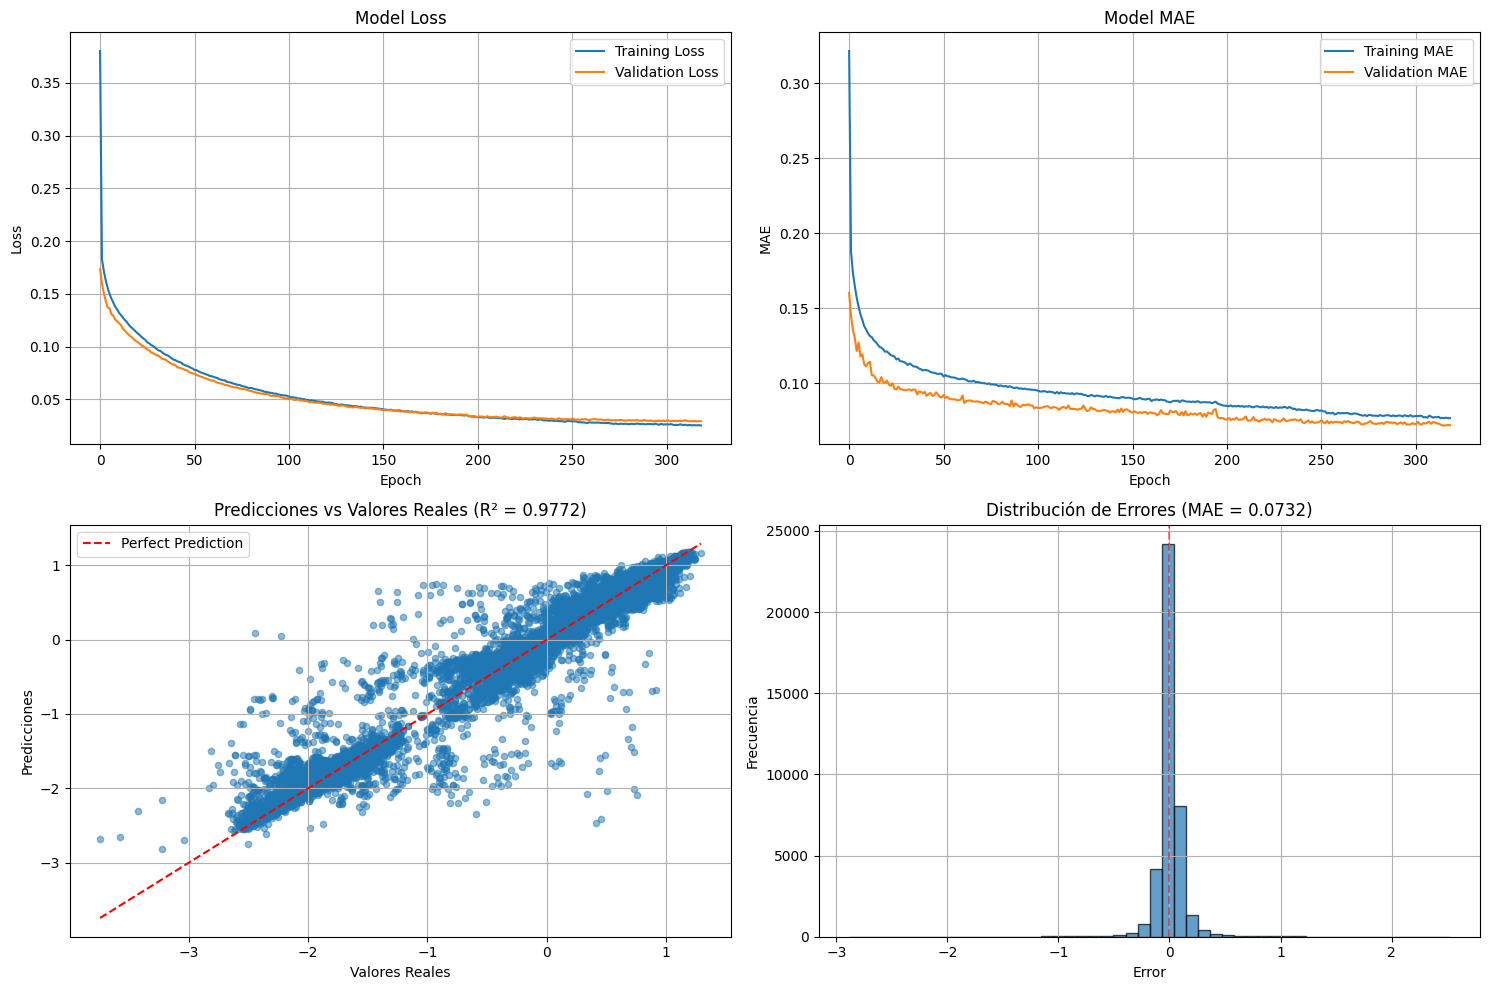

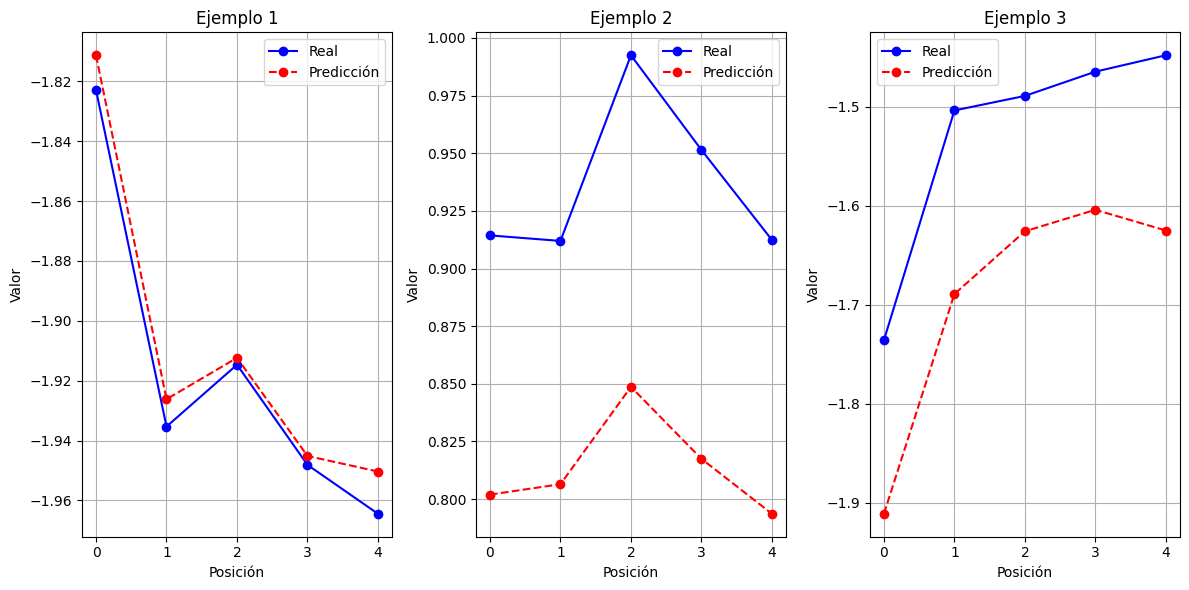

In [6]:
# ----------------------------------------
# 6. EVALUACIÓN Y VISUALIZACIÓN
# ----------------------------------------
# Evaluar
test_metrics = model.evaluate([X_test, trunk_test], Y_test, verbose=1)
print(f"\nTest loss (MSE): {test_metrics[0]:.4f}")
import time
 
# Hacer predicciones
ini = time.time()
Y_pred = model.predict([X_test, trunk_test])
fin = time.time()
print(f"Total execution time: {fin - ini:.4f} seconds")
print(len(X_test))
 
# Asegurar que Y_pred tenga la forma correcta (8000, 5)
if Y_pred.shape != Y_test.shape:
    Y_pred = Y_pred.reshape(Y_test.shape)


# Aplanar arrays para métricas y visualización
Y_test_flat = Y_test.ravel()
Y_pred_flat = Y_pred.ravel()


# Calcular métricas
mse = np.mean((Y_pred_flat - Y_test_flat)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(Y_pred_flat - Y_test_flat))
r2 = 1 - np.sum((Y_test_flat - Y_pred_flat)**2) / np.sum((Y_test_flat - np.mean(Y_test_flat))**2)

# [Resto del código de visualización igual que antes...]

# Imprimir métricas
print("\nMétricas de evaluación:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Visualizaciones
plt.figure(figsize=(15, 10))

# 1. Gráfico de pérdida durante el entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Gráfico de MAE durante el entrenamiento
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# 3. Scatter plot de predicciones vs valores reales
plt.subplot(2, 2, 3)
plt.scatter(Y_test_flat, Y_pred_flat, alpha=0.5, s=20)
min_val = min(np.min(Y_test_flat), np.min(Y_pred_flat))
max_val = max(np.max(Y_test_flat), np.max(Y_pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Predicciones vs Valores Reales (R² = {r2:.4f})')
plt.legend()
plt.grid(True)

# 4. Histograma de errores
plt.subplot(2, 2, 4)
errors = Y_pred_flat - Y_test_flat
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title(f'Distribución de Errores (MAE = {mae:.4f})')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualizar algunas predicciones específicas
plt.figure(figsize=(12, 6))
for i in range(3):  # Mostrar 3 ejemplos
    plt.subplot(1, 3, i+1)
    plt.plot(range(5), Y_test[i], 'bo-', label='Real')
    plt.plot(range(5), Y_pred[i], 'ro--', label='Predicción')
    plt.title(f'Ejemplo {i+1}')
    plt.xlabel('Posición')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
